In [1]:
import scanpy as sc
import scvi
import pandas as pd

/Users/aathreyakadambi/Documents/software/python/anaconda/anaconda3/envs/omics/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# gene expression

## preprocessing

In [2]:
# data source: # https://www.biorxiv.org/content/10.1101/2025.09.11.675724v1.full - PacBio long reads
# files paths 

CARMELLE_DATA_DIR = "/mnt/lareaulab/carmelle/longread_sc/lung"
AATH_DATA_DIR = "/Users/aathreyakadambi/Documents/school/berkeley/fa25/cs194/final_project/data"
DATA_DIR = AATH_DATA_DIR

# sn
sn_gene = f'{DATA_DIR}/sn/GSM9135509_pb_sn_genes_count_matrix.tsv.gz'
sn_isoform = f'{DATA_DIR}/sn/GSM9135509_pb_sn_transcript_count_matrix.mtx.gz'

# sc
sc_gene = f'{DATA_DIR}/sc/GSM9135508_pb_sc_genes_count_matrix.tsv.gz'
sc_isoform = f'{DATA_DIR}/sc/GSM9135508_pb_sc_transcript_count_matrix.mtx.gz'

In [3]:
adata_sn_gene = sc.read_csv(sn_gene).transpose()
adata_sc_gene = sc.read_csv(sc_gene).transpose()

In [4]:
adata_sn_gene, adata_sc_gene

(AnnData object with n_obs × n_vars = 10001 × 49671,
 AnnData object with n_obs × n_vars = 5002 × 50394)

In [5]:
adata_sn_gene.var_names, adata_sc_gene.var_names

(Index(['ENSG00000211952.3', 'ENSG00000211955.2', 'ENSG00000211956.2',
        'ENSG00000211957.2', 'ENSG00000211958.2', 'ENSG00000211959.2',
        'ENSG00000231475.3', 'ENSG00000238275.2', 'ENSG00000253240.1',
        'ENSG00000253325.1',
        ...
        'ENSG00000283791.1', 'ENSG00000285533.4', 'ENSG00000286756.3',
        'ENSG00000289259.2', 'ENSG00000289339.2', 'ENSG00000289740.1',
        'ENSG00000289883.1', 'ENSG00000290026.1', 'ENSG00000290061.1',
        'ENSG00000291174.1'],
       dtype='object', length=49671),
 Index(['ENSG00000212380.1', 'ENSG00000270814.1', 'ENSG00000280234.1',
        'ENSG00000211938.2', 'ENSG00000211943.2', 'ENSG00000211947.2',
        'ENSG00000211949.3', 'ENSG00000211950.2', 'ENSG00000211952.3',
        'ENSG00000211955.2',
        ...
        'ENSG00000210174.1', 'ENSG00000210176.1', 'ENSG00000210184.1',
        'ENSG00000210191.1', 'ENSG00000210194.1', 'ENSG00000210195.2',
        'ENSG00000210196.2', 'ENSG00000211459.2', 'ENSG00000212907.2'

### check some qc metrics

In [6]:
sc.pp.calculate_qc_metrics(adata_sc_gene, inplace=True)
sc.pp.calculate_qc_metrics(adata_sn_gene, inplace=True)

In [7]:
#looks good
adata_sn_gene.obs['n_genes_by_counts'].mean(), adata_sc_gene.obs['n_genes_by_counts'].mean()

(np.float64(4348.82201779822), np.float64(7170.528988404638))

### convert feature names from ENSEMBL ID's to gene symbols

In [8]:
import mygene

In [9]:
mg = mygene.MyGeneInfo()

In [10]:
ensembl_clean_sn = [x.split('.')[0] for x in adata_sn_gene.var_names]
ensembl_clean_sc = [x.split('.')[0] for x in adata_sc_gene.var_names]

In [11]:
all_ensembl_ids = set(ensembl_clean_sc) | set(ensembl_clean_sn)
len(all_ensembl_ids)

52931

In [12]:
# use to query
results = mg.querymany(all_ensembl_ids, scopes='ensembl.gene', fields='symbol', species='human')

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
30 input query terms found dup hits:	[('ENSG00000227110', 2), ('ENSG00000215156', 2), ('ENSG00000228566', 2), ('ENSG00000257545', 2), ('E
1138 input query terms found no hit:	['ENSG00000261273', 'ENSG00000256321', 'ENSG00000286941', 'ENSG00000248103', 'ENSG00000227192', 'ENS


In [13]:
ensembl_map = {}

for item in results:
    if ('query' in item) and ('symbol' in item):
        ensembl_map[item['query']] = item['symbol']
    else:
        ensembl_map[item['query']] = item['query']

In [14]:
ensembl_map

{'ENSG00000283503': 'LINC01902',
 'ENSG00000213925': 'NPM1P33',
 'ENSG00000130307': 'USHBP1',
 'ENSG00000232748': 'ENSG00000232748',
 'ENSG00000260612': 'ENSG00000260612',
 'ENSG00000152439': 'ZNF773',
 'ENSG00000259296': 'ENSG00000259296',
 'ENSG00000142515': 'KLK3',
 'ENSG00000232133': 'IMPDH1P10',
 'ENSG00000181929': 'PRKAG1',
 'ENSG00000289379': 'ENSG00000289379',
 'ENSG00000288701': 'PRRC2B',
 'ENSG00000207000': 'RNU6-820P',
 'ENSG00000276950': 'GSTT4',
 'ENSG00000233729': 'NCKAP5-AS1',
 'ENSG00000011376': 'LARS2',
 'ENSG00000227110': 'LOC101927394',
 'ENSG00000266282': 'UBL5P2',
 'ENSG00000260340': 'LINC02176',
 'ENSG00000167131': 'DNAAF19',
 'ENSG00000152078': 'TLCD4',
 'ENSG00000249850': 'KRT18P31',
 'ENSG00000269656': 'NOP53-AS1',
 'ENSG00000261273': 'ENSG00000261273',
 'ENSG00000241926': 'MTCO1P55',
 'ENSG00000215237': 'ENSG00000215237',
 'ENSG00000292285': 'ENSG00000292285',
 'ENSG00000291000': 'LOC101929863',
 'ENSG00000153157': 'SYCP2L',
 'ENSG00000256321': 'ENSG0000025632

In [15]:
sn_gene_symbols = [ensembl_map[x] for x in ensembl_clean_sn]
sc_gene_symbols = [ensembl_map[x] for x in ensembl_clean_sc]

In [16]:
len(ensembl_clean_sn), len(sn_gene_symbols)

(49671, 49671)

In [17]:
len(ensembl_clean_sc), len(sc_gene_symbols)

(50394, 50394)

In [18]:
#reassign the list of genes symbols to var_names

adata_sn_gene.var_names = sn_gene_symbols
adata_sc_gene.var_names = sc_gene_symbols

In [19]:
adata_sc_gene.var_names[:10], adata_sc_gene.var_names[:10]

(Index(['SNORD115-45', 'DMAC1P1', 'ENSG00000280234', 'IGHV3-7', 'IGHV3-15',
        'IGHV3-21', 'IGHV3-23', 'IGHV1-24', 'IGHV4-28', 'IGHV3-33'],
       dtype='object'),
 Index(['SNORD115-45', 'DMAC1P1', 'ENSG00000280234', 'IGHV3-7', 'IGHV3-15',
        'IGHV3-21', 'IGHV3-23', 'IGHV1-24', 'IGHV4-28', 'IGHV3-33'],
       dtype='object'))

## concatenate datasets

In [20]:
#add batch labels
adata_sn_gene.obs['batch'] = 'single nuclei'
adata_sc_gene.obs['batch'] = 'single cell'


In [21]:
#no repeat barcodes 

adata_sn_gene.obs_names_make_unique()
adata_sc_gene.obs_names_make_unique()

#no repeat features
adata_sn_gene.var_names_make_unique()
adata_sc_gene.var_names_make_unique()


In [22]:
genes_combined = sc.concat([adata_sc_gene, adata_sn_gene], 
                   join='inner', 
                   label='dataset',
                   keys=['single cell', 'single nuclei'])

/Users/aathreyakadambi/Documents/software/python/anaconda/anaconda3/envs/omics/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [23]:
genes_combined

AnnData object with n_obs × n_vars = 15003 × 47196
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'batch', 'dataset'

In [24]:
#no repeat barcodes and features in integrated dataset

genes_combined.obs_names_make_unique()
genes_combined.var_names_make_unique()

In [25]:
genes_combined

AnnData object with n_obs × n_vars = 15003 × 47196
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'batch', 'dataset'

In [26]:
genes_combined.obs['batch'].value_counts()

batch
single nuclei    10001
single cell       5002
Name: count, dtype: int64

In [27]:
sc.pp.filter_cells(genes_combined, min_genes=200)
sc.pp.filter_genes(genes_combined, min_cells=3)

#print after filtering
genes_combined

AnnData object with n_obs × n_vars = 15002 × 46359
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'batch', 'dataset', 'n_genes'
    var: 'n_cells'

In [28]:
genes_combined.var['n_cells']

SNORD115-45            6
DMAC1P1                6
ENSG00000280234       16
IGHV3-33              40
IGHV4-34              45
                   ...  
MT-TT                 45
MT-TP               4710
MT-RNR1            13934
MT-ND4L             6983
MT-ATP8             4099
Name: n_cells, Length: 46359, dtype: int64

In [29]:
genes_combined.layers['counts'] = genes_combined.X

# visualize without correcting for batch effect

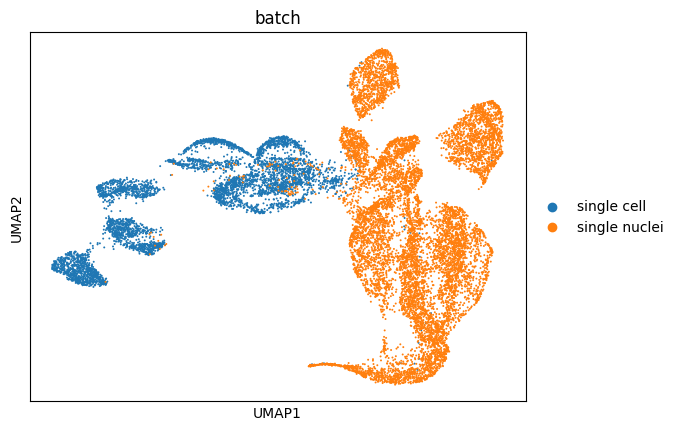

In [30]:
sc.tl.pca(genes_combined)
sc.pp.neighbors(genes_combined, n_pcs=30, n_neighbors=20)
sc.tl.umap(genes_combined, min_dist=0.3)
sc.pl.umap(genes_combined, color=['batch'], wspace=0.55)

# scVI

In [31]:
sc.pp.highly_variable_genes(
    genes_combined,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
)

In [32]:
scvi.model.SCVI.setup_anndata(
    genes_combined,
    layer="counts",
    batch_key="batch",
)

In [33]:
model = scvi.model.SCVI(genes_combined)
model

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [34]:
model.train(max_epochs=20)

/Users/aathreyakadambi/Documents/software/python/anaconda/anaconda3/envs/omics/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/aathreyakadambi/Documents/software/python/anaconda/anaconda3/envs/omics/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/aathreyakadambi/Documents/software/python/anaconda/anaconda3/envs/omics/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Co

Epoch 20/20: 100%|██████████| 20/20 [01:00<00:00,  3.78s/it, v_num=1, train_loss_step=685, train_loss_epoch=683]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [01:00<00:00,  3.00s/it, v_num=1, train_loss_step=685, train_loss_epoch=683]


In [35]:
SCVI_LATENT_KEY = "X_scVI"

latent = model.get_latent_representation()
genes_combined.obsm[SCVI_LATENT_KEY] = latent
latent.shape

(15002, 10)

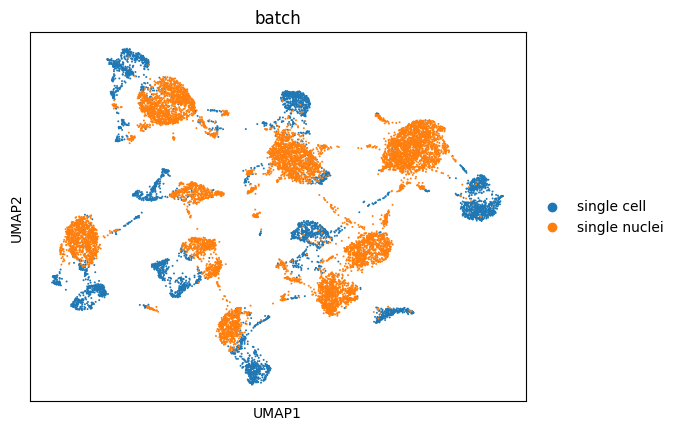

In [36]:
sc.pp.neighbors(genes_combined, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(genes_combined, min_dist=0.3)
sc.pl.umap(genes_combined, color=['batch'], wspace=0.55)

In [37]:
genes_combined.write_h5ad('integrated_sc_sn_gene-exp.h5ad')